# `009-linreg-learner`

Task: Fit a linear regression by gradient descent.

## Setup

In [19]:
from fastai.vision.all import *

This function will make a `DataLoaders` object out of an arary dataset.

In [20]:
def make_dataloaders(x, y_true, splitter, batch_size):
    data = L(zip(x, y_true))
    train_indices, valid_indices = splitter(data)
    return DataLoaders(
        DataLoader(data[train_indices], batch_size=batch_size, shuffle=True),
        DataLoader(data[valid_indices], batch_size=batch_size)
    )   

Here are utility functions to plot the first axis of a dataset and a model's predictions.

In [92]:
def plot_data(x, y): plt.scatter(x[:, 0], y[:, 0], s=1)
def plot_model(x, model):
    x = x.sort(dim=0).values
    y_pred = model(x).detach()
    plt.plot(x[:, 0], y_pred[:, 0], 'r')

## Task

Remember this? Suppose we have a dataset with just a single feature `x` and continuous outcome variable `y`.

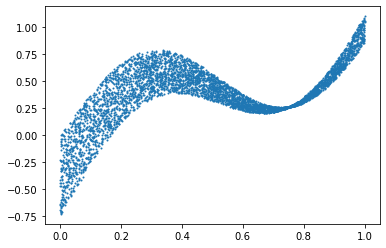

In [313]:
torch.manual_seed(0)
x = torch.rand(5000, 1)
noise = torch.rand_like(x) * 1.
y_true = .5 * (x*6).sin() + x + (x - .75) * noise

plot_data(x, y_true)

Let's try to learn this function! We'll first do a linear regression, then extend it to a simple neural network.

In [314]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)
batch_size = 20
dataloaders = make_dataloaders(x, y_true, splitter, batch_size=batch_size)

1. Fit a line to this data (minimizing the MSE). Evaluate the MSE. By eye, how well does it fit?
2. Use `nn.Sequential` to put two `nn.Linear` layers back to back. Use 100 dimensions as the hidden dimension (the `out_features` of the first and the `in_features` of the second). Evaluate the MSE. How well does it fit?
3. Now, add a `nn.ReLU` between the two linear layers. Evaluate the MSE. How well does it fit?

## Solution

**Fit a line to this data (minimizing the MSE).**

epoch,train_loss,valid_loss,mae,time
0,0.054909,0.055520,0.194901,00:00
1,0.058307,0.054861,0.195379,00:00
2,0.056774,0.055816,0.195218,00:00
3,0.057613,0.056914,0.196215,00:00
4,0.059260,0.054862,0.195235,00:00
5,0.057871,0.055279,0.194534,00:00
6,0.057070,0.055628,0.196784,00:00
7,0.058196,0.055641,0.196394,00:00
8,0.056832,0.056018,0.195181,00:00
9,0.057752,0.055254,0.195298,00:00


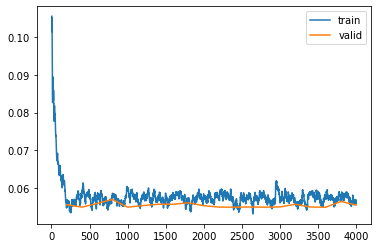

In [315]:
model = nn.Linear(in_features=1, out_features=1, bias=True)
loss_func = nn.MSELoss()

learner = Learner(
    dls=dataloaders,
    model=model,
    loss_func=loss_func,
    opt_func=SGD,
    metrics=[mae]
)

learner.fit(n_epoch=20, lr=1e-1)
learner.recorder.plot_loss()

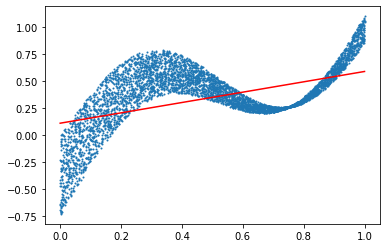

In [316]:
plot_data(x, y_true)
plot_model(x, model)

Evaluate the MSE. By eye, how well does it fit?

epoch,train_loss,valid_loss,mae,time
0,0.056695,0.056928,0.192482,00:00
1,0.056774,0.055099,0.193436,00:00
2,0.055672,0.055137,0.194019,00:00
3,0.053779,0.055022,0.195255,00:00
4,0.058345,0.054850,0.195082,00:00
5,0.055348,0.054871,0.194680,00:00
6,0.056035,0.054819,0.194946,00:00
7,0.055795,0.054831,0.195080,00:00
8,0.056338,0.054897,0.195213,00:00
9,0.057815,0.054888,0.195245,00:00


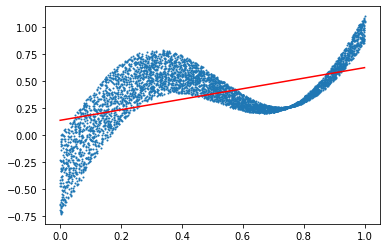

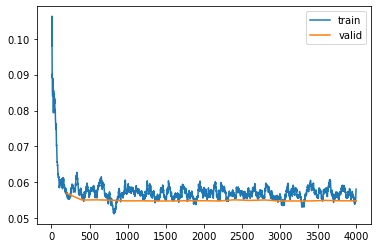

In [317]:
# Inspired by https://gist.github.com/oguiza/c7559da6de0e036f01d7dee15e2f15e4
class ShowPredictions(Callback):
    def __init__(self): self.graph_fig = None
    def after_fit(self): plt.close(self.graph_fig)
    def after_epoch(self):
        if self.graph_fig is None:
            self.graph_fig, self.graph_ax = plt.subplots(1)
            self.graph_out = display(self.graph_ax.figure, display_id=True)
        plt.sca(self.graph_ax)
        self.graph_ax.clear()
        plot_data(x, y_true)
        plot_model(x, model)
        self.graph_out.update(self.graph_ax.figure)

model = nn.Sequential(
    nn.Linear(in_features=1, out_features=100, bias=True),
    nn.Linear(in_features=100, out_features=1, bias=True),
)
loss_func = nn.MSELoss()

learner = Learner(
    dls=dataloaders,
    model=model,
    loss_func=loss_func,
    opt_func=SGD,
    metrics=[mae],
    cbs=ShowPredictions()
)

learner.fit(n_epoch=20, lr=1e-3)
learner.recorder.plot_loss()

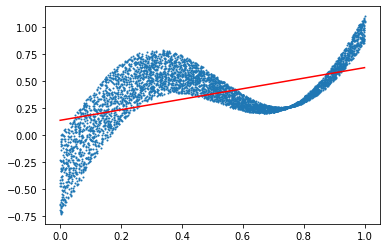

In [318]:
plot_data(x, y_true)
plot_model(x, model)

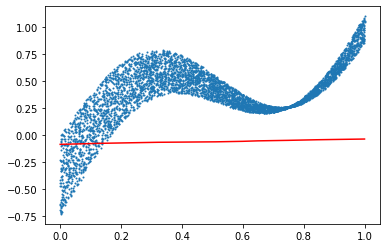

In [319]:
model = nn.Sequential(
    nn.Linear(1, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 1)
)
#model[0].requires_grad_(False)
#model[0].weight.data[:] = 1
#model[0].bias.copy_(torch.linspace(-2, 2, 100))
plot_data(x, y_true)
plot_model(x, model)

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.0008317637839354575)

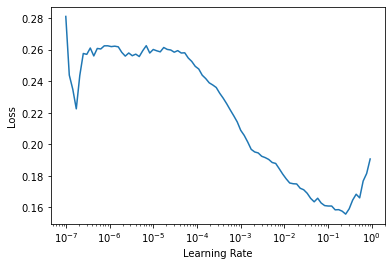

In [320]:
# Inspired by https://gist.github.com/oguiza/c7559da6de0e036f01d7dee15e2f15e4
class ShowPredictions(Callback):
    def __init__(self): self.graph_fig = None
    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, 'gather_preds')
    def after_fit(self): plt.close(self.graph_fig)
    def after_epoch(self):
        if self.graph_fig is None:
            self.graph_fig, self.graph_ax = plt.subplots(1)
            self.graph_out = display(self.graph_ax.figure, display_id=True)
        plt.sca(self.graph_ax)
        self.graph_ax.clear()
        plot_data(x, y_true)
        plot_model(x, model)
        self.graph_out.update(self.graph_ax.figure)

learner = Learner(
    dls=dataloaders,
    model=model,
    loss_func=loss_func,
    opt_func=partial(SGD, mom=0.9),
    metrics=[mae],
    wd=1e-3,
    cbs=ShowPredictions()
)
learner.lr_find()

epoch,train_loss,valid_loss,mae,time
0,0.045031,0.042819,0.167095,00:01
1,0.029206,0.026374,0.132408,00:00
2,0.020418,0.019655,0.103490,00:00
3,0.015345,0.013439,0.086844,00:00
4,0.014519,0.013025,0.084424,00:00
5,0.014475,0.013565,0.086489,00:00
6,0.013929,0.013226,0.086000,00:00
7,0.013660,0.012584,0.082035,00:00
8,0.013510,0.012526,0.080695,00:00
9,0.013592,0.013203,0.081620,00:00


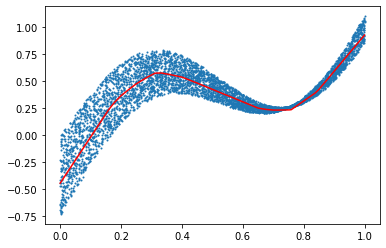

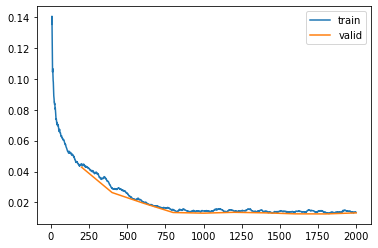

In [321]:
learner.fit(n_epoch=10, lr=1e-2)
learner.recorder.plot_loss()

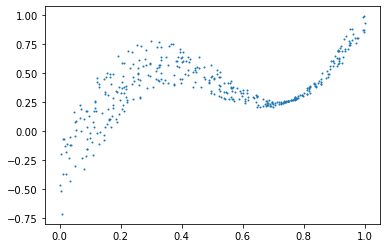

In [294]:
train_indices, valid_indices = splitter(x)
plot_data(x[train_indices], y_true[train_indices])

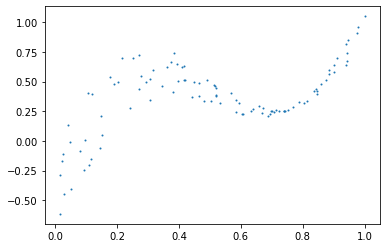

In [295]:
train_indices, valid_indices = splitter(x)
plot_data(x[valid_indices], y_true[valid_indices])

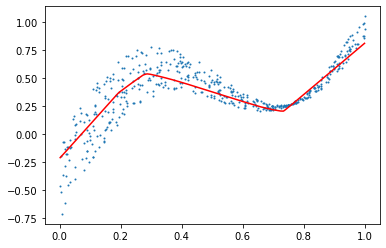

In [296]:
plot_data(x, y_true)
plot_model(x, model)

In [265]:
(model[:2](x) > 0).float().mean(dim=0)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2320, 0.0000, 0.2320,
        0.0000, 0.0000, 0.0000, 0.2540, 0.2560, 0.2560, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000, 0.2560, 0.0000, 0.0000,
        0.2320, 0.0000, 0.2560, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2320, 0.2600, 0.2320,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2320, 0.0000, 0.2680, 0.0080,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2540, 0.2680, 0.0000,
        0.2560, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2560, 0.2320, 0.0000, 0.0000, 0.0000, 0.0020, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2320, 0.2320, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

(array([4.7983e+04, 4.9500e+02, 5.1500e+02, 3.6000e+02, 2.4400e+02,
        1.8800e+02, 1.0800e+02, 6.5000e+01, 2.5000e+01, 1.7000e+01]),
 array([0.        , 0.02752788, 0.05505576, 0.08258364, 0.11011151,
        0.13763939, 0.16516727, 0.19269514, 0.22022302, 0.2477509 ,
        0.27527878], dtype=float32),
 <BarContainer object of 10 artists>)

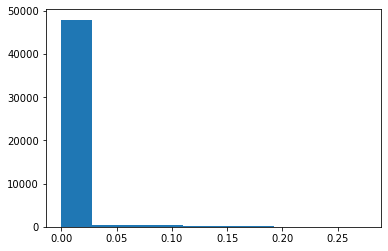

In [259]:
plt.hist(model[:2](x).detach().numpy().flatten())

## Analysis

Inspect the `weight` and `bias` attributes of `model`. How close are they to the ideal values? Explain.

In [17]:
# ...
print(model.weight)

Parameter containing:
tensor([[3.9724]], requires_grad=True)


In [18]:
# ...
print(model.bias)

Parameter containing:
tensor([-0.7291], requires_grad=True)


## Extension (optional)

Suppose we rerun this notebook hundreds of times with different random seeds. What is the expected value of the validation loss? 

Answer this by looking at the way that `y_true` was constructed.

(Assume that the model gets enough training data that `weights` and `bias` get exactly the right values. It turns out that this assumption isn't actually needed, but it will make it easier to think about where the error comes from.)